# Problem statemen:
A very basic cat not a cat image recognition. this was taken from the C1W4 DL specialization's last assignment, but doing it using tf instead of coding it using only numpy.

In [1]:
# Importing packages:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

2023-01-22 11:24:35.014575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 11:24:35.180403: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 11:24:35.180424: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-22 11:24:36.148447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Loading the data:

def load_data():
    train_dataset = h5py.File('../Datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../Datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
# exploring the data:

print(f'train_x_orig shape: {train_x_orig.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x_orig shape: {test_x_orig.shape}')
print(f'test_y shape: {test_y.shape}')

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


We have 209 training examples, and 50 testing examples, each of them is a 64 * 64 * 3 picture.
We need to flatten them for further analysis.

In [4]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [5]:
x_train = train_x_orig.reshape(209,-1)
x_test = test_x_orig.reshape(50,-1)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (209, 12288)
x_test shape: (50, 12288)


displaying 16 random images of the data:

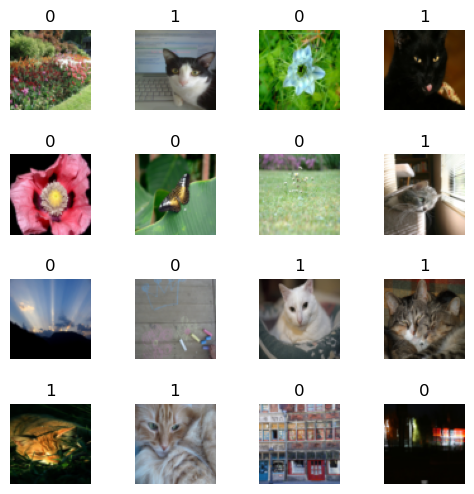

In [6]:
m,n = x_train.shape

fig, ax = plt.subplots(4,4,figsize=(5,5))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    ax.imshow(x_train[rand].reshape(64,64,3), cmap='gray')
    ax.set_title(train_y.T[rand][0])
    ax.set_axis_off()

## Logistic Regression:

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(x_train, train_y.T.ravel())

LogisticRegression(max_iter=500)

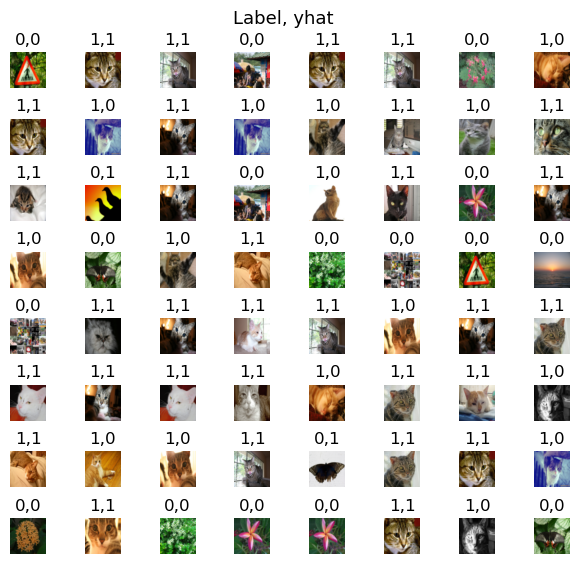

In [8]:
fig, ax = plt.subplots(8,8, figsize=(6,6))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92])
m,n = x_test.shape

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    prediction = model.predict(x_test[rand].reshape(1,12288))
    if prediction >= 0.5:
        yhat=1
    else:
        yhat=0
    
    ax.imshow(x_test[rand].reshape(64,64,3))
    true = test_y.T[rand][0]
    ax.set_title(f'{true},{yhat}')
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=13);

In [9]:
prediction=np.zeros(x_test.shape[0])
for i in range(50):
    predict = model.predict(x_test[i].reshape(1,12288))
    if predict >= 0.5:
        yhat=1
    else:
        yhat=0
    prediction[i] = yhat

prediction

array([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.])

In [10]:
test_y.shape

(1, 50)

In [11]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediction.ravel(),test_y.T)
acc

0.72

We achieved 72% accuracy using logistic regression.

## Neural Networks:

In [12]:
model = tf.keras.models.Sequential([
                                    tf.keras.Input(shape=(12288,)),
                                    tf.keras.layers.Dense(units=20, activation='relu'),
                                    tf.keras.layers.Dense(units=7, activation='relu'),
                                    tf.keras.layers.Dense(units=5, activation='relu'),
                                    tf.keras.layers.Dense(units=1, activation='sigmoid')
                                    ])
        
                

2023-01-22 11:24:45.153890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-22 11:24:45.153936: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-22 11:24:45.153962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hashem-Latitude-E6540): /proc/driver/nvidia/version does not exist
2023-01-22 11:24:45.154740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                245780    
                                                                 
 dense_1 (Dense)             (None, 7)                 147       
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.000005)
             )

In [15]:
model.fit(x_train, train_y.T, epochs=1000)

Epoch 1/1000
7/7 [==============================] - 1s 8ms/step - loss: 7.2614
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.3803
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.8614
Epoch 4/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.0804
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4485
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.1555
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.8717
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5677
Epoch 9/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.3596
Epoch 10/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.0922
Epoch 11/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9129
Epoch 12/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.7804
Epoch 13/1000
7/7 [==============================

In [16]:
yhat = model.predict(x_test[6].reshape(1,12288))
yhat

1/1 [==============================] - 0s 103ms/step


array([[0.9982548]], dtype=float32)

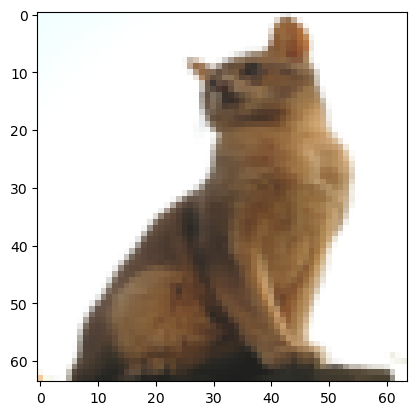

In [17]:
plt.imshow(x_test[6].reshape(64,64,3))

1/1 [==============================] - 0s 26ms/step


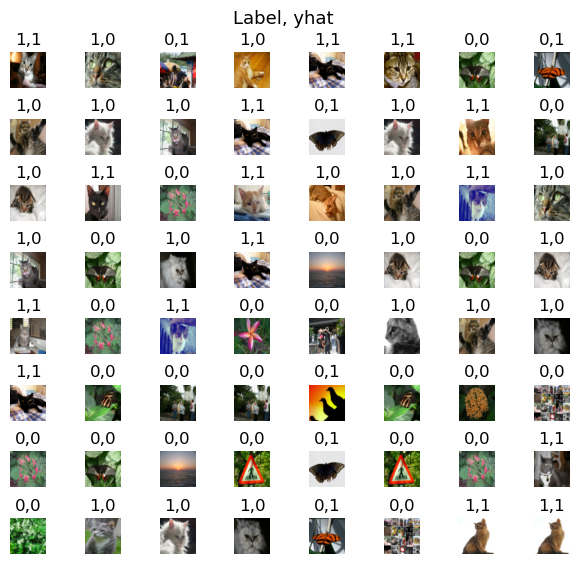

In [18]:
fig, ax = plt.subplots(8,8, figsize=(6,6))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92])
m,n = x_test.shape

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    prediction = model.predict(x_test[rand].reshape(1,12288))
    if prediction >= 0.5:
        yhat=1
    else:
        yhat=0
    
    ax.imshow(x_test[rand].reshape(64,64,3))
    true = test_y.T[rand][0]
    ax.set_title(f'{true},{yhat}')
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=13);

In [19]:
prediction=np.zeros(x_test.shape[0])
for i in range(50):
    predict = model.predict(x_test[i].reshape(1,12288))
    if predict >= 0.5:
        yhat=1
    else:
        yhat=0
    prediction[i] = yhat

prediction

1/1 [==============================] - 0s 21ms/step


array([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.])

In [20]:
acc = accuracy_score(prediction.ravel(),test_y.T)
acc

0.64

I was able to get an accuracy of 74% on kaggle using their GPU to train with 5000 epochs. Check kaggle for details.